In [19]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [21]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt

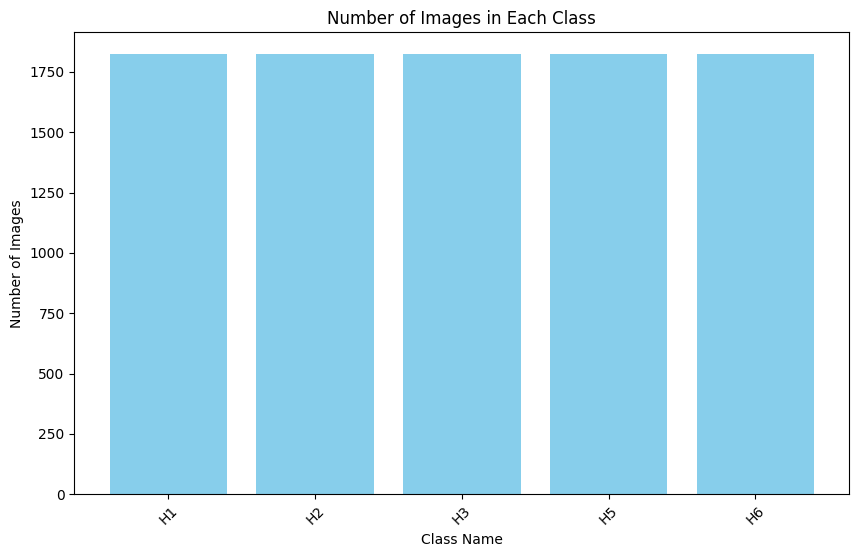

In [23]:
import matplotlib.pyplot as plt

input_folder = "defungi2"

class_names = os.listdir(input_folder)

num_images_per_class = []
for class_name in class_names:
    class_folder = os.path.join(input_folder, class_name)
    num_images = len(os.listdir(class_folder))
    num_images_per_class.append(num_images)

plt.figure(figsize=(10, 6))
plt.bar(class_names, num_images_per_class, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=45)
plt.show()


In [24]:
import os
import shutil
from sklearn.model_selection import train_test_split

input_folder = "defungi"
output_folder = "output"

class_names = os.listdir(input_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for class_name in class_names:
    class_folder = os.path.join(input_folder, class_name)
    output_train_folder = os.path.join(output_folder, "train", class_name)
    output_test_folder = os.path.join(output_folder, "test", class_name)
    os.makedirs(output_train_folder, exist_ok=True)
    os.makedirs(output_test_folder, exist_ok=True)

    images = os.listdir(class_folder)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    for image in train_images:
        src = os.path.join(class_folder, image)
        dest = os.path.join(output_train_folder, image)
        shutil.copy(src, dest)

    for image in test_images:
        src = os.path.join(class_folder, image)
        dest = os.path.join(output_test_folder, image)
        shutil.copy(src, dest)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'output/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=64,
    image_size=(256, 256),
    seed=42
)

class_names = train_dataset.class_names
class_names

Found 7290 files belonging to 5 classes.


['H1', 'H2', 'H3', 'H5', 'H6']

In [25]:
image_size = 256

data_generator_with_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True,
)

data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator_with_aug.flow_from_directory(
        'output/train',
        target_size=(image_size, image_size),
        batch_size=64,
        class_mode='categorical',
        shuffle=False)

validation_generator = data_generator_no_aug.flow_from_directory(
        'output/test',
        target_size=(image_size, image_size),
        batch_size=64,
        class_mode='categorical',
        shuffle=False)

Found 7290 images belonging to 5 classes.
Found 1824 images belonging to 5 classes.


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# Load InceptionV3 base model
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)  # num_classes is the number of output classes

# Define model
model = Model(inputs=base_model.input, outputs=output)

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',patience=8)

In [10]:
model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=80,
    verbose=1,
    callbacks = [early_stopping]
)

Epoch 1/80
114/114 [==============================] - 66s 506ms/step - loss: 1.6798 - accuracy: 0.4849 - val_loss: 2.0651 - val_accuracy: 0.4090
Epoch 2/80
114/114 [==============================] - 31s 271ms/step - loss: 1.3191 - accuracy: 0.5257 - val_loss: 1.0357 - val_accuracy: 0.6096
Epoch 3/80
114/114 [==============================] - 32s 277ms/step - loss: 1.2040 - accuracy: 0.5508 - val_loss: 1.0488 - val_accuracy: 0.5839
Epoch 4/80
114/114 [==============================] - 32s 283ms/step - loss: 1.1311 - accuracy: 0.5645 - val_loss: 0.9492 - val_accuracy: 0.6157
Epoch 5/80
114/114 [==============================] - 33s 285ms/step - loss: 1.0656 - accuracy: 0.5820 - val_loss: 0.9394 - val_accuracy: 0.6228
Epoch 6/80
114/114 [==============================] - 33s 286ms/step - loss: 1.0518 - accuracy: 0.5850 - val_loss: 0.9401 - val_accuracy: 0.6201
Epoch 7/80
114/114 [==============================] - 33s 288ms/step - loss: 1.0028 - accuracy: 0.6063 - val_loss: 0.9646 - val_ac

In [11]:
hist = model.history

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [12]:
hist = hist.history

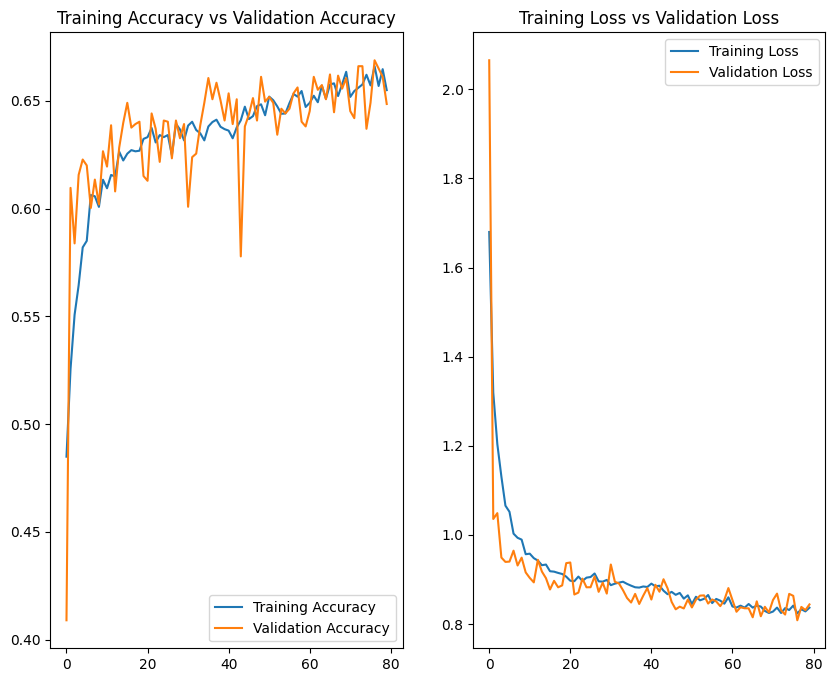

In [13]:
acc=hist['accuracy']
val_acc=hist['val_accuracy']

loss=hist['loss']
val_loss=hist['val_loss']

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.plot(range(80),acc,label='Training Accuracy')
plt.plot(range(80),val_acc,label='Validation Accuracy')
plt.legend()
plt.title("Training Accuracy vs Validation Accuracy")


plt.subplot(1,2,2)
plt.plot(range(80),loss,label='Training Loss')
plt.plot(range(80),val_loss,label='Validation Loss')
plt.title("Training Loss vs Validation Loss")
plt.legend()
plt.show()

In [14]:
model.save("models/v35.h5")

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import tensorflow as tf

model = tf.keras.models.load_model("models/v35.h5")

test_loss, test_accuracy = model.evaluate(validation_generator, verbose=1)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


29/29 [==============================] - 13s 379ms/step - loss: 0.8440 - accuracy: 0.6486
Test Loss: 0.8440064787864685
Test Accuracy: 0.6485745906829834


In [27]:
from sklearn.metrics import precision_recall_fscore_support

predicted_probabilities = model.predict(validation_generator, verbose=1)

true_labels = []
for x, y in validation_generator:
    true_labels.extend(np.argmax(y, axis=1))
    if len(true_labels) >= len(predicted_probabilities):
        break

predicted_labels = np.argmax(predicted_probabilities, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


29/29 [==============================] - 7s 207ms/step
Precision: 0.6413201164510449
Recall: 0.6485745614035088
F1-score: 0.6024557417177752


In [33]:
from sklearn.metrics import classification_report

predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = validation_generator.classes

class_report = classification_report(true_labels, predicted_labels, target_names=class_names)

print("Classification Report:")
print(class_report)


29/29 [==============================] - 6s 212ms/step
Classification Report:
              precision    recall  f1-score   support

          H1       0.65      0.95      0.77       881
          H2       0.55      0.24      0.33       467
          H3       0.76      0.23      0.35       164
          H5       0.67      0.65      0.66       164
          H6       0.74      0.64      0.69       148

    accuracy                           0.65      1824
   macro avg       0.67      0.54      0.56      1824
weighted avg       0.64      0.65      0.60      1824



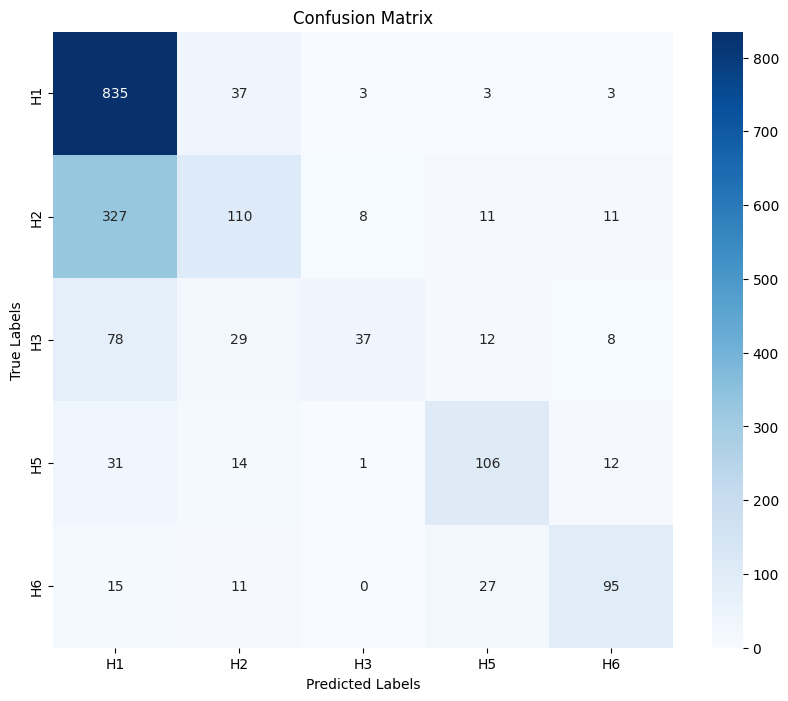

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(image_path, target_size=(256, 256)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = preprocess_input(img_array)
    return img_array

def predict_images(model, image_paths, class_names):
    predictions = []
    for img_path in image_paths:
        img_array = load_and_preprocess_image(img_path)
        pred_probs = model.predict(img_array)
        predicted_class_index = np.argmax(pred_probs)
        predicted_class = class_names[predicted_class_index]
        predictions.append(predicted_class)
    return predictions

image_paths = ["defungi/H6/H6_2a_15.jpg","defungi/H2/H2_1a_1.jpg","defungi/H3/H3_1b_1.jpg","defungi/H5/H5_1a_1.jpg","defungi/H3/H3_2a_10.jpg"]
predicted_classes = predict_images(model, image_paths, class_names)
for i, predicted_class in enumerate(predicted_classes):
    print(f"Image {i+1} Predicted Class:", predicted_class)



1/1 [==============================] - 0s 34ms/step
Image 1 Predicted Class: H1
Image 2 Predicted Class: H1
Image 3 Predicted Class: H1
Image 4 Predicted Class: H1
Image 5 Predicted Class: H1
